In [ ]:
# Đề 7 - MSV: 2251262656
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv('train.csv')

df_friday = df[df['Publication_Day'] == 'FriFriday']
df_friday

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
6,6,Criminal Minds,Episode 47,69.83,True Crime,35.82,Sunday,Night,39.02,0.0,Neutral,64.75024
16,16,Study Sessions,Episode 82,78.47,Education,48.84,Sunday,Afternoon,NaN,2.0,Neutral,42.89441
18,18,Digital Digest,Episode 72,7.34,Technology,20.81,Sunday,Night,83.06,3.0,Positive,0.75783
42,42,Innovators,Episode 17,32.29,Technology,89.36,Sunday,Evening,42.61,3.0,Neutral,26.57501
46,46,Mind & Body,Episode 2,92.81,Health,28.52,Sunday,Evening,24.65,0.0,Positive,53.58589
...,...,...,...,...,...,...,...,...,...,...,...,...
749976,749976,Mind & Body,Episode 56,76.54,Health,76.63,Sunday,Night,76.56,1.0,Neutral,59.74578
749979,749979,Tech Trends,Episode 82,50.58,Technology,68.52,Sunday,Evening,67.64,3.0,Positive,40.18565
749980,749980,Humor Hub,Episode 13,67.03,Comedy,96.63,Sunday,Evening,94.28,3.0,Negative,50.44000
749983,749983,Current Affairs,Episode 52,92.34,News,55.93,Sunday,Evening,89.57,1.0,Neutral,53.15589


## Basic Kalma Filter 

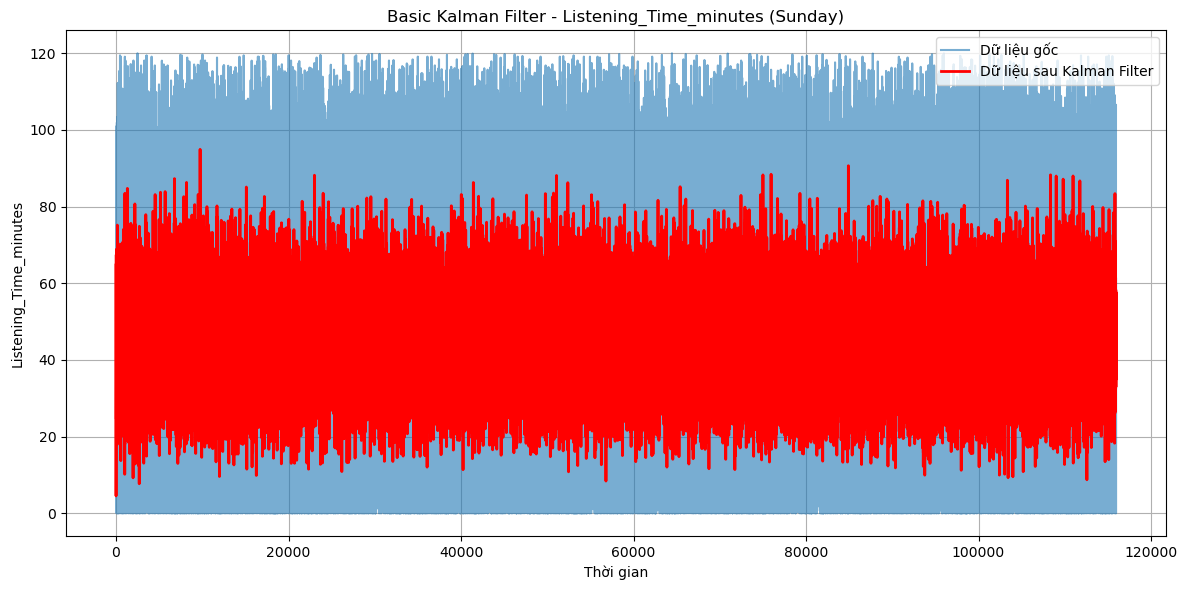

In [ ]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
data_col = 'Listening_Time_minutes'
data = df_friday[data_col].dropna().values

# Khởi tạo Basic Kalman Filter
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([data[0], 0.])  # giá trị ban đầu, tốc độ
kf.F = np.array([[1., 1.], [0., 1.]])  # ma trận chuyển đổi trạng thái
kf.H = np.array([[1., 0.]])           # ma trận đo
kf.P *= 1000.                         # hiệp phương sai ban đầu
kf.R = 10                             # nhiễu đo
kf.Q = Q_discrete_white_noise(dim=2, dt=1, var=0.01)  # Nhiễu hệ thống

# Lọc tuần tự
filtered = []
for z in data:
    kf.predict()
    kf.update(z)
    filtered.append(kf.x[0])

plt.figure(figsize=(12, 6))
plt.plot(data, label='Dữ liệu gốc', alpha=0.6)
plt.plot(filtered, label='Dữ liệu sau Kalman Filter', color='red', linewidth=2)
plt.title('Basic Kalman Filter - Listening_Time_minutes (Sunday)')
plt.xlabel('Thời gian')
plt.ylabel('Listening_Time_minutes')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Smooth Kalma Filter

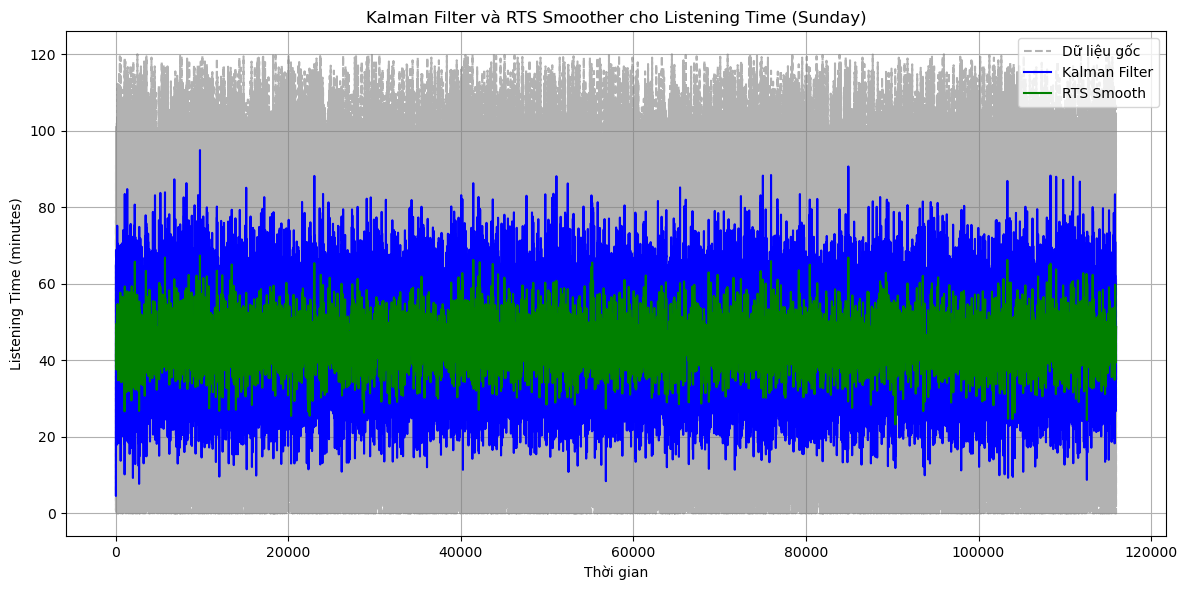

In [ ]:
# Làm mượt bằng RTS smoother
smoothed_mu, smoothed_cov, _, _ = kf.rts_smoother(mu, cov)

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(data, label='Dữ liệu gốc', color='gray', linestyle='--', alpha=0.6)
plt.plot(mu[:, 0], label='Kalman Filter', color='blue')
plt.plot(smoothed_mu[:, 0], label='RTS Smooth', color='green')
plt.title('Kalman Filter và RTS Smoother cho Listening Time (Sunday)')
plt.xlabel('Thời gian')
plt.ylabel('Listening Time (minutes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

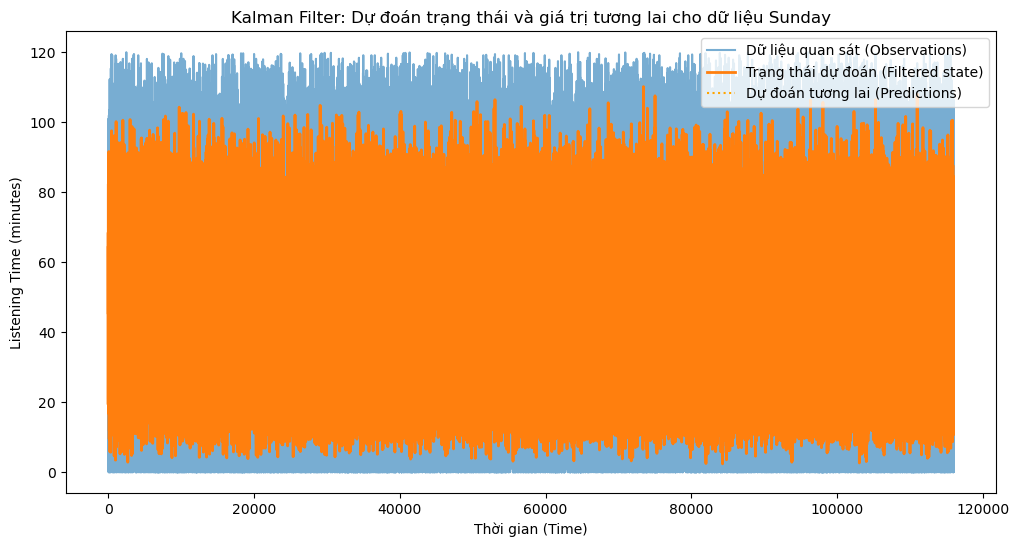

In [50]:
# Kalman Filter với tham số cố định
class SimpleKalmanFilter:
    def __init__(self, initial_state, initial_covariance, process_covariance, measurement_covariance):
        self.state = initial_state  # Trạng thái ban đầu
        self.covariance = initial_covariance  # Hiệp phương sai ban đầu
        self.process_covariance = process_covariance  # Nhiễu hệ thống (Q)
        self.measurement_covariance = measurement_covariance  # Nhiễu đo (R)
    
    def predict(self):
        # Tiên đoán trạng thái tiếp theo 
        self.state = self.state  # Trạng thái không thay đổi 
        self.covariance = self.covariance + self.process_covariance  # Cập nhật hiệp phương sai dựa vào nhiễu

    def update(self, measurement):
        # Cập nhật trạng thái với phép đo mới (z_k = H * x_k + v_k)
        kalman_gain = self.covariance / (self.covariance + self.measurement_covariance)
        self.state = self.state + kalman_gain * (measurement - self.state)
        self.covariance = (1 - kalman_gain) * self.covariance

# Lọc dữ liệu quan sát
filtered_state = []

# Lọc qua tất cả các dữ liệu quan sát
for z in data:
    kf.predict()  # Tiên đoán giá trị tiếp theo
    kf.update(z)  # Cập nhật với giá trị thực tế
    filtered_state.append(kf.state)

# Dự đoán giá trị tương lai
future_steps = 10  # Dự đoán 10 bước tiếp theo
predictions = []

# Tiên đoán giá trị cho các bước tiếp theo mà không có dữ liệu quan sát
for _ in range(future_steps):
    kf.predict()  # Tiên đoán giá trị cho bước tiếp theo
    predictions.append(kf.state)

# Vẽ kết quả
plt.figure(figsize=(12, 6))
plt.plot(data, label='Dữ liệu quan sát (Observations)', alpha=0.6)
plt.plot(filtered_state, label='Trạng thái dự đoán (Filtered state)', linewidth=2)
plt.plot(range(len(data), len(data) + future_steps), predictions, label='Dự đoán tương lai (Predictions)', linestyle='dotted', color='orange')
plt.legend()
plt.title("Kalman Filter: Dự đoán trạng thái và giá trị tương lai cho dữ liệu Sunday")
plt.xlabel("Thời gian (Time)")
plt.ylabel("Listening Time (minutes)")
plt.show()
